# Heartbeat Sounds

### [Classifying heartbeat anomalies from stethoscope audio](https://www.kaggle.com/kinguistics/heartbeat-sounds)

**Useful Links**

    1. https://github.com/sevenfx/fastai_audio/tree/master/notebooks
    2. https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89
    3. https://medium.com/@navdeepsingh_2336/identifying-the-genre-of-a-song-with-neural-networks-851db89c42f0
    4. https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8
    5. http://deepsound.io/music_genre_recognition.html
    6. https://medium.com/@juliendespois/finding-the-genre-of-a-song-with-deep-learning-da8f59a61194

### Imports

In [2]:
! conda install -y -q -c conda-forge librosa

Solving environment: ...working... done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36

  added / updated specs: 
    - librosa


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    librosa-0.6.3              |             py_0         1.5 MB  conda-forge
    resampy-0.2.1              |             py_1         330 KB  conda-forge
    joblib-0.13.2              |             py_0         180 KB  conda-forge
    audioread-2.1.6            |           py36_0          30 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.0 MB

The following NEW packages will be INSTALLED:

    audioread:       2.1.6-py36_0      conda-forge
    joblib:          0.13.2-py_0       conda-forge
    librosa:         0.6.3-py_0        conda-forge
    resampy:         0.2.1-py_1     

In [1]:
#import librosa
import os
import pandas as pd
import numpy as np
import fnmatch
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
#import librosa.display
import shutil
plt.ioff()

PATH = "C:\\Users\\frapo\\Downloads\\heartbeat-sounds"
PATH = "/tmp/data"

### Functions

In [2]:
def load_wave(fname):
    y, sr = librosa.load(os.path.join(PATH, fname))
    return y

def build_dataset():
    path_to_ = os.path.join(PATH, "heartbeats.pkl")
    if os.path.isfile(path_to_):
        df = pd.read_pickle(path_to_)
    else:
        murmurs = ['set_b/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_b'), 'murmur*.wav')]
        murmurs += ['set_a/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_a'), 'murmur*.wav')]
        murmurs += murmurs
        labels = ["murmur"] * len(murmurs)
        
        normals = ['set_b/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_b'), 'normal*.wav')]
        normals += ['set_a/'+ m for m in fnmatch.filter(os.listdir(PATH+'/set_a'), 'normal*.wav')]
        labels += ["normal"] * len(normals)
        
        df = pd.DataFrame({"fname": murmurs+normals, "label": labels})
        df["array"] = df.fname.apply(load_wave)
        df["len_series"] = df["array"].apply(len)
        df['image_names'] = df.fname.apply(lambda x: x.replace("/", "-").replace("wav", "jpg"))
        df = df.sample(frac=1)
        df.to_pickle(path_to_)
    
    return df

def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

def explore_heartbeat(i):
    print(f"i: {i}")
    label = data.iloc[i].label
    fname = data.iloc[i].fname
    print(f"label: {label}; fname: {fname}")
    if label not in fname: return "Incostintent label"
    
    y, sr = librosa.load(os.path.join(PATH, fname))
    d = librosa.get_duration(y=y, sr=sr)
    print(f"Before padding sr: {sr}; len: {len(y)}; duration (s): {d}")
    
    y_ext = repeat_to_length(y, MAX_LEN)
    d = librosa.get_duration(y=y_ext, sr=sr)
    print(f"After padding sr: {sr}; len: {len(y_ext)}; duration: {d}")
    
    fig, ax = plt.subplots(figsize=(15, 3))
    librosa.display.waveplot(y, sr=sr)
    ax.set_title(f'label={label}; waveplot')
    
    X = librosa.stft(y)
    Xdb = librosa.amplitude_to_db(abs(X))
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    ax.set_title(f'label={label}; spectrogram: stft, amp2db, log')
    
    #my_dpi = 120
    #fig, ax = plt.subplots(figsize=(512/my_dpi, 512/my_dpi), dpi=my_dpi)
    
    mfccs = librosa.feature.mfcc(y, sr=sr)
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis='log')
    ax.set_title(f'label={label}; spectrogram: mfcc, log')

    mel_spec = librosa.feature.melspectrogram(y, sr=sr, fmin=10, fmax=2000, power=1.0)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)    
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='log')
    ax.set_title(f'label={label}; spectrogram: melspectrogram, amp2db, log, fmax=2k hz')
    
    plt.show()
    
    return fname, Xdb, y

def get_melspectrogram(y, sr):
    mel_spec = librosa.feature.melspectrogram(y, sr=sr, fmin=10, fmax=2000, power=1.0)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)  
    return mel_spec_db

def produce_spect_image(spec, sr, name):
    fig, ax = plt.subplots(figsize=(15, 5))
    librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')    
    ax.axis('off')
    plt.savefig(name, bbox_inches=None, pad_inches=0)
    plt.close(fig)
    
def load_and_pad(fname):
    y, sr = librosa.load(fname)
    y = repeat_to_length(y, MAX_LEN)
    return y, sr

def save_spectrograms(df):
    
    directory = os.path.join(PATH, "spects")
    if os.path.exists(directory): shutil.rmtree(directory)
    os.makedirs(directory)
    
    for i, row in df.iterrows():
        fname = os.path.join(PATH, row.fname)
        image_name = os.path.join(directory, row.image_names)
        
        y, sr = load_and_pad(fname)
        spec = get_melspectrogram(y, sr)
        produce_spect_image(spec, sr, image_name)
        
    mxn = df.copy().reset_index()
    mxn["is_murmur"] = mxn.label.apply(lambda x: int(x == "murmur"))
    
    return mxn[["index", "is_murmur", "image_names"]]

def save_lst(x, name):
    x.to_csv(os.path.join(PATH, 'temp.lst'), index=False, header=None, sep='\t')
    
    with open(os.path.join(PATH, 'temp.lst'), "rt") as fin:
        with open(os.path.join(PATH, name), "wt") as fout:
            for line in fin:
                fout.write(line.replace('"', ''))

### Load dataset and explore

In [4]:
#files = os.listdir(os.path.join(PATH, "spects"))
#d = pd.DataFrame({"files": files})
#e = data.merge(d, left_on="image_names", right_on="files", how="left")
#e.loc[pd.isnull(e.files)]

In [3]:
data = build_dataset()
MAX_LEN = max(data["len_series"])

assert MAX_LEN == 614468
assert isinstance(data.array[0].sum(), np.float32)
assert data.shape == (609, 5)

In [6]:
data.sample(5)

,fname,label,array,len_series,image_names
605,set_a/normal__201108011112.wav,normal,"[0.0070946957, 0.011353447, 0.010698099, 0.011...",174979,set_a-normal__201108011112.jpg
337,set_b/normal_noisynormal_157_1306937583792_B.wav,normal,"[-0.010117396, -0.011175282, -0.011769793, -0....",374911,set_b-normal_noisynormal_157_1306937583792_B.jpg
242,set_a/murmur__201108222233.wav,murmur,"[-0.00416366, -0.006745719, -0.006495577, -0.0...",174979,set_a-murmur__201108222233_bis.jpg
408,set_b/normal__134_1306428161797_C.wav,normal,"[0.018717324, 0.020230066, 0.020604646, 0.0199...",75467,set_b-normal__134_1306428161797_C.jpg
462,set_b/normal__170_1307970562729_B.wav,normal,"[-0.04388865, -0.047321334, -0.04808776, -0.04...",168192,set_b-normal__170_1307970562729_B.jpg


i: 65
label: murmur; fname: set_b/murmur_noisymurmur_200_1308144251434_D.wav
Before padding sr: 22050; len: 166076; duration (s): 7.531791383219955
After padding sr: 22050; len: 614468; duration: 27.86702947845805


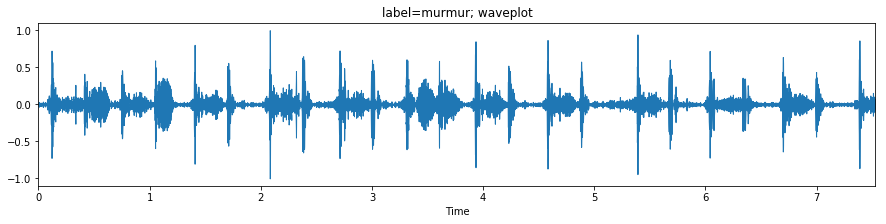

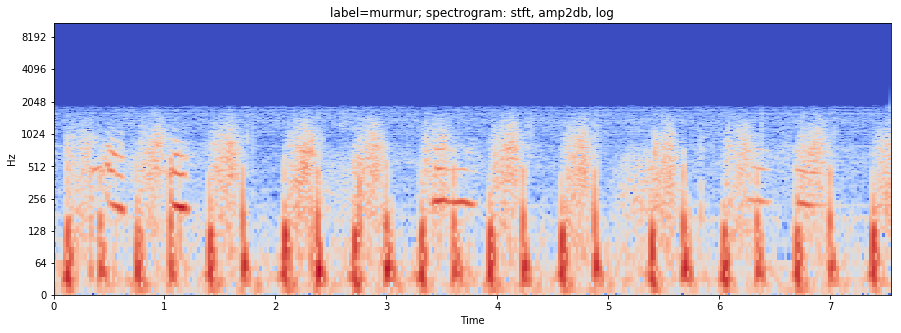

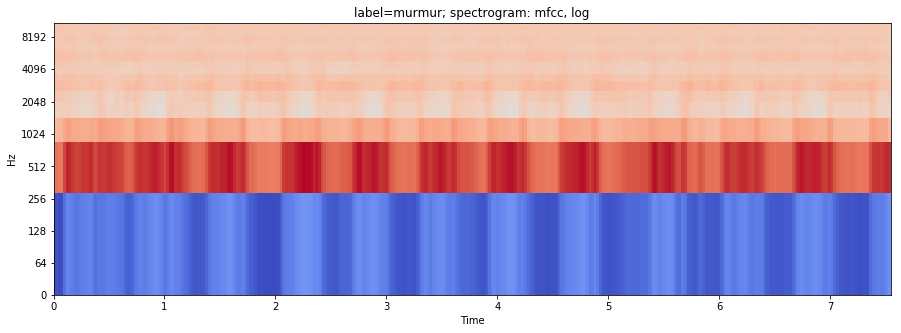

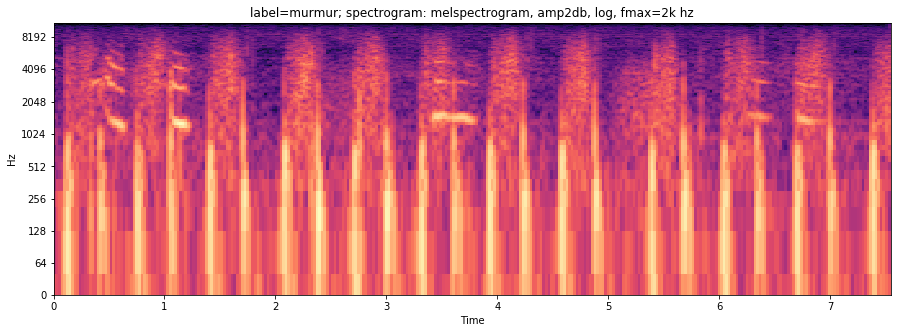

In [7]:
i = np.random.randint(low=0, high=(len(data)-1))
fname, Xdb, y = explore_heartbeat(i)
ipd.Audio(os.path.join(PATH, fname))

### Prepare dataset for deep learning

In [11]:
lst = save_spectrograms(data)

In [13]:
assert lst.shape[0] == data.shape[0]

In [17]:
raw_train = lst.sample(int(len(lst)*.8), random_state=42).sample(frac=1)
raw_valid = lst.loc[~lst.index.isin(raw_train.index)].sample(frac=1)

raw_train.shape, raw_valid.shape

((487, 3), (122, 3))

In [20]:
raw_train.is_murmur.sum()/len(raw_train), raw_valid.is_murmur.sum()/len(raw_valid)

(0.4394250513347023, 0.36065573770491804)

In [21]:
save_lst(raw_train, 'train.lst')
save_lst(raw_valid, 'valid.lst')

In [10]:
! head {PATH}/train.lst

168	1	set_b-murmur__160_1307100683334_B.jpg
94	1	set_b-murmur__293_1311680805936_B1.jpg
256	1	set_a-murmur__201108222256.jpg
268	0	set_b-normal_noisynormal_109_1305653972028_A.jpg
87	1	set_b-murmur__281_1311165683454_A.jpg
37	1	set_b-murmur__156_1306936373241_B.jpg
458	0	set_b-normal__168_1307970069434_A.jpg
0	1	set_b-murmur_noisymurmur_135_1306428972976_A.jpg
251	1	set_a-murmur__201108222248.jpg
526	0	set_b-normal__220_1308250132896_C.jpg


In [2]:
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo
from mxnet.gluon import utils as gutils
import subprocess
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from skimage import io

import mxnet as mx
from mxnet import lr_scheduler
import pandas as pd
import os
import cv2

In [6]:
def standard_transform(data, label):
    data = data.astype('float32')
    augs = mx.image.CreateAugmenter(data_shape=(3, 224, 224))
    for aug in augs:
        data = aug(data)
    return data, label

def train_aug_transform(data, label):
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3,224,224),
                                    rand_crop=0.5, rand_resize=0.5, 
                                    mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, label

def valid_aug_transform(data, label):
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3,224,224),
                                    mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, label

def _get_batch(batch, ctx):
    """Return features and labels on ctx."""
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
    """Train and evaluate a model."""
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar()
                                 for y_hat, y in zip(y_hats, ys)])
            m += sum([y.size for y in ys])
        test_acc, test_loss = evaluate_accuracy(test_iter, net, ctx)
        if test_acc > 0.65:
            print('Validation accuracy > 65%. Saving model...')
            timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
            mod_name = ARCH + timestamp
            net.export(mod_name)
        print('epoch %d, train loss %.4f, test loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, test_loss, train_acc_sum / m, test_acc,
                 time.time() - start))
    return net
        
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    """Evaluate accuracy of a model on the given data set."""
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    loss_sum, acc_sum, n, m = 0.0, 0.0, 0, 0
    loss = gloss.SoftmaxCrossEntropyLoss()
    for batch in data_iter:
        Xs, ys, batch_size = _get_batch(batch, ctx)
        y_hats = [net(X) for X in Xs]
        ys = [y.astype('float32') for y in ys]
        ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
        loss_sum += sum([l.sum().asscalar() for l in ls])
        n += sum([l.size for l in ls])
        acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar() for y_hat, y in zip(y_hats, ys)])
        m += sum([y.size for y in ys])        
        
    return acc_sum / m, loss_sum / n

def build_graph(which_net):
    if which_net == 'resnet34':
        pretrained_net = model_zoo.vision.resnet34_v2(pretrained=True)
        finetune_net = model_zoo.vision.resnet34_v2(classes=2)
    if which_net == 'resnet50':
        pretrained_net = model_zoo.vision.resnet50_v2(pretrained=True)
        finetune_net = model_zoo.vision.resnet50_v2(classes=2)
    if which_net == 'vgg16':
        pretrained_net = model_zoo.vision.vgg16_bn(pretrained=True)
        finetune_net = model_zoo.vision.vgg16_bn(classes=2)
    
    finetune_net.features = pretrained_net.features
    finetune_net.output.initialize(init.Xavier())
    return finetune_net

def train_fine_tuning(net, folder, learning_rate, freeze=True, batch_size=64, num_epochs=5, scheduler=False, wd=0.001):
    
    training_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(folder, 'train.rec'), 
                                                           transform=train_aug_transform)
    validation_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(folder, 'valid.rec'), 
                                                            transform=valid_aug_transform)
    
    train_iter = mx.gluon.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    test_iter = mx.gluon.data.DataLoader(validation_dataset, batch_size=batch_size)

    ctx = mx.gpu()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gloss.SoftmaxCrossEntropyLoss()
    
    if freeze:
        params = net.output.collect_params()
    else:
        net.output.collect_params().setattr('lr_mult', 100)
        params = net.collect_params()
        learning_rate /= 100
    
    
    hyperparams = {'learning_rate': learning_rate}
    if scheduler:
        schedule = lr_scheduler.FactorScheduler(step=7, factor=0.7)
        hyperparams['lr_scheduler'] = schedule
    if wd is not None:
        hyperparams['wd'] = wd
    
    trainer = gluon.Trainer(params, 'adam', hyperparams)
    return train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs)

def show_batch(rec_file):
    dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(FOLDER, rec_file),
                                                     transform=standard_transform)
    loader = mx.gluon.data.DataLoader(dataset, batch_size=64, shuffle=True)
    x, y = next(iter(loader))
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i,ax in enumerate(axes.flat):
        im = (x[i])
        labels = ['Other', 'Thriller/Crime'][int(y[i].asnumpy()[0])]
        title = labels
        ax.set_title(title)
        ax.set_axis_off()
        ax.imshow((im.clip(0, 255)/255).asnumpy())

In [4]:
training_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(PATH, 'train.rec'), transform=train_aug_transform)
train_iter = mx.gluon.data.DataLoader(training_dataset, batch_size=64, shuffle=True)

In [5]:
x, y = next(iter(train_iter))
x.shape, y.shape

((64, 3, 512, 512), (64,))

In [7]:
ARCH = 'vgg16'
model = build_graph(ARCH)

In [8]:
model = train_fine_tuning(model, PATH, 0.001, freeze=True, batch_size=32)

training on gpu(0)
Validation accuracy > 65%. Saving model...
epoch 1, train loss 0.6082, test loss 0.5168, train acc 0.671, test acc 0.721, time 57.1 sec
Validation accuracy > 65%. Saving model...
epoch 2, train loss 0.5307, test loss 0.4082, train acc 0.741, test acc 0.820, time 24.3 sec
Validation accuracy > 65%. Saving model...
epoch 3, train loss 0.4399, test loss 0.4198, train acc 0.805, test acc 0.779, time 24.2 sec
Validation accuracy > 65%. Saving model...
epoch 4, train loss 0.4748, test loss 0.4089, train acc 0.791, test acc 0.811, time 24.1 sec
Validation accuracy > 65%. Saving model...
epoch 5, train loss 0.4674, test loss 0.4368, train acc 0.758, test acc 0.795, time 24.2 sec


In [9]:
model = train_fine_tuning(model, PATH, 0.0001, freeze=False, batch_size=32)

training on gpu(0)
Validation accuracy > 65%. Saving model...
epoch 1, train loss 0.4520, test loss 0.4327, train acc 0.819, test acc 0.803, time 25.7 sec
Validation accuracy > 65%. Saving model...
epoch 2, train loss 0.4059, test loss 0.4123, train acc 0.823, test acc 0.811, time 25.0 sec
Validation accuracy > 65%. Saving model...
epoch 3, train loss 0.4002, test loss 0.4127, train acc 0.825, test acc 0.811, time 25.2 sec
Validation accuracy > 65%. Saving model...
epoch 4, train loss 0.4315, test loss 0.4038, train acc 0.811, test acc 0.811, time 25.1 sec
Validation accuracy > 65%. Saving model...
epoch 5, train loss 0.3975, test loss 0.4036, train acc 0.836, test acc 0.811, time 25.0 sec


In [10]:
model = train_fine_tuning(model, PATH, 0.0001, freeze=False, batch_size=32)

training on gpu(0)
Validation accuracy > 65%. Saving model...
epoch 1, train loss 0.4672, test loss 0.4188, train acc 0.768, test acc 0.811, time 22.1 sec
Validation accuracy > 65%. Saving model...
epoch 2, train loss 0.4372, test loss 0.4017, train acc 0.807, test acc 0.803, time 22.1 sec
Validation accuracy > 65%. Saving model...
epoch 3, train loss 0.4349, test loss 0.3956, train acc 0.807, test acc 0.820, time 22.1 sec
Validation accuracy > 65%. Saving model...
epoch 4, train loss 0.4236, test loss 0.3858, train acc 0.807, test acc 0.811, time 22.0 sec
Validation accuracy > 65%. Saving model...
epoch 5, train loss 0.4101, test loss 0.3742, train acc 0.817, test acc 0.795, time 22.0 sec
